# Illumination correction

Due to reduced intensity illumination/collection away from the optical axis of the objective lens, it is typical for many microscopes (particularly camera-based systems) to have an illumination bias near the edges of the field-of-view.

To correct for this, we use typically use the [BaSiC method](https://doi.org/10.1038/ncomms14836) to derive two correction matrices from a reference sample. These can then be applied to the raw data to correct the biases. This is implemented in the ``basicpy`` package [https://github.com/peng-lab/BaSiCPy]. This package also covers correction of time-lapse data. We consider both cases in this example.  

## Uneven illumination across the field-of-view

Note: You must run ``notebooks/0_setup.ipynb`` first to specify the configuration and download the test data.

In [1]:
import napari
import numpy as np
import pandas as pb
import basicpy
from aicsimageio import AICSImage
from matplotlib import pyplot as plt

from blimp.data import load_example_data
from blimp.log import configure_logging
from blimp.constants import blimp_config
from aicsimageio import AICSImage
from pathlib import Path

configure_logging(verbosity=2)
# ensure that example data is downloaded
load_example_data()
# read correct blimp_config -- created with 0_setup.ipynb
blimp_config.config_fname = "blimp.ini"
# load the exampledata configuration
example_data_config = blimp_config.get_data_config('exampledata')
print(blimp_config)

Reading config from /Users/scottberry/source/blimp/notebooks/blimp.ini
unpacked_dir = /Users/scottberry/source/blimp/notebooks/_data/raw
archive_path = /Users/scottberry/source/blimp/notebooks/_data/archive/_data.zip
Reading config from blimp.ini
BLIMPConfig (fname: blimp.ini)
EXPERIMENT_DIR: /Users/scottberry/source/blimp/notebooks/_experiments
BASE_DATA_DIR: /Users/scottberry/source/blimp/notebooks/_data/raw
data_config/exampledata: /Users/scottberry/source/blimp/notebooks/ExampleData_constants.py



The following images are dyes in solution (Alexa-488, Alexa-568, Alexa-647) imaged on the Nikon N-storm. To use both images (from different positions), these can be combined along the 'T' axis of the ``AICSImage``. 

In [2]:
bf1 = AICSImage(Path(example_data_config.DATA_DIR) / 'nstorm_illumination_bias' /  '221103_brightfield_488_568_647_1.nd2')
bf2 = AICSImage(Path(example_data_config.DATA_DIR) / 'nstorm_illumination_bias' /  '221103_brightfield_488_568_647_2.nd2')

# here we use 'T' as the multi-point axis
bf = AICSImage(
    np.stack(
        [
            bf1.get_image_dask_data('CZYX'),
            bf2.get_image_dask_data('CZYX'),
        ],
        axis=0),
    physical_pixel_sizes = bf1.physical_pixel_sizes,
    channel_names=bf1.channel_names
)

In [ ]:
bf.shape

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
im = axes[0].imshow(bf.get_image_data('YX',C=0,T=0), vmin=0, vmax=350)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("488")
im = axes[1].imshow(bf.get_image_data('YX',C=1,T=0), vmin=0, vmax=1500)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("568")
im = axes[2].imshow(bf.get_image_data('YX',C=2,T=0), vmin=0, vmax=1500)
fig.colorbar(im, ax=axes[2])
axes[2].set_title("647")
fig.tight_layout()

We can use basicpy to correct these artefacts

In [ ]:
illum_corr = [basicpy.BaSiC() for _ in range(3)]
[illum_corr[c].fit(bf.get_image_data('TYX',C=c)) for c in range(3)]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
im = axes[0].imshow(illum_corr[0].flatfield)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Flatfield")
im = axes[1].imshow(illum_corr[0].darkfield)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Darkfield")
axes[2].plot(illum_corr[0].baseline)
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Baseline")
fig.tight_layout()

In [ ]:
bf_transformed = illum_corr[0].transform(bf.get_image_data('TYX',C=0))
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
im = axes[0].imshow(bf.get_image_data('YX',C=0,T=0), vmin=0, vmax=300)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Original")
im = axes[1].imshow(bf_transformed[1], vmin=0, vmax=300)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Corrected")
fig.tight_layout()

If a brightfield image is not avaliable, this can be generated by averaging or concatenating a set of input images

## BLIMP interface

Rather than dealing directly with the basicpy package. ``blimp`` wraps the functionality to act directly on ``AICSImage``s.

In [3]:
from blimp.preprocessing.illumination_correction import IlluminationCorrection, correct_illumination
illumination_correction = IlluminationCorrection(reference_images=[bf1,bf2], timelapse=False)

2023-02-08 01:49:02 | INFO     | Remote TPU is not linked into jax; skipping remote TPU. [[_make_tpu_driver_client @ /Users/scottberry/opt/anaconda3/envs/berrylab-default/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:173]]
2023-02-08 01:49:02 | INFO     | Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver' [[backends @ /Users/scottberry/opt/anaconda3/envs/berrylab-default/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:357]]
2023-02-08 01:49:02 | INFO     | Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig' [[backends @ /Users/scottberry/opt/anaconda3/envs/berrylab-default/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:357]]
2023-02-08 01:49:02 | INFO     | Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig' [[backends @ /Users/scottberry/opt/anaconda3/envs/berrylab-default/lib/python3.8/site-packages/jax/_src/lib/xla_bridge

When using reference images to fit ``IlluminationCorrection``, additional keyword arguments as specified in ``basicpy.BaSiC`` will be used, for example:

In [4]:
illumination_correction = IlluminationCorrection(reference_images=[bf1,bf2], timelapse=False, smoothness_flatfield=1, smoothness_darkfield=5)

These can then be applied to correct images using either a procedural or object oriented interface

In [4]:
# object-oriented
bf1_corrected_oo = illumination_correction.correct(bf1)

# procedural
bf1_corrected_pr = correct_illumination(bf1, illumination_correction)

np.all(np.equal(bf1_corrected_pr.get_image_data(), bf1_corrected_oo.get_image_data()))

True

These functions also accept lists of images

In [5]:
# object-oriented
bf_corrected_oo = illumination_correction.correct([bf1, bf2])

# procedural
bf_corrected_pr = correct_illumination([bf1,bf2], illumination_correction)


In [6]:
bf_corrected_oo

[<AICSImage [Reader: ArrayLikeReader, Image-is-in-Memory: False]>,
 <AICSImage [Reader: ArrayLikeReader, Image-is-in-Memory: False]>]

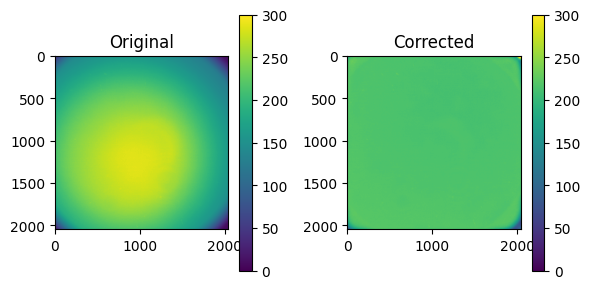

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
im = axes[0].imshow(bf1.get_image_data('YX',C=0,T=0), vmin=0, vmax=300)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Original")
im = axes[1].imshow(bf1_corrected_oo.get_image_data('YX',C=0,T=0), vmin=0, vmax=300)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Corrected")
fig.tight_layout()

The ``IlluminationCorrection`` class has ``save`` and ``load`` methods

In [4]:
import os
results_path = Path(example_data_config.EXPERIMENT_DIR) / "illumination_correction"
if not results_path.exists():
    os.makedirs(results_path)

In [15]:
illumination_correction.save(results_path / "bf.pkl")
illumination_correction_from_file = IlluminationCorrection(from_file = results_path / "bf.pkl")

# alternatively, a file can be loaded into an IlluminationCorrection object already instantiated\n",
illumination_correction_from_file = IlluminationCorrection()
illumination_correction_from_file.load(results_path / "bf.pkl")

In [19]:
print(illumination_correction_from_file)

None


In [12]:
import pickle
with open(illumination_correction.file_path,'wb') as f:
    pickle.dump(illumination_correction, f)

In [ ]:
a = correct_image(bf1,correction_objects)
a.dims

In [ ]:
correction_objects[0].transform(bf1.get_image_data('YX',C=0,Z=0,T=0))[0].shape

In [ ]:
bf1.get_image_data('YX',C=0,Z=0,T=0).shape

In [ ]:
images = unbleached_images[0:2]
av = average_images(images)
concat = concatenate_images(images)

In [ ]:
av.shape

In [ ]:
concat.shape

In [ ]:
unbleached_images = [AICSImage("/srv/scratch/berrylab/z3532965/Nikon_AX_QPI/20221010_BleachChase_POLR2A/20221010_160654_024/OME-TIFF-MIP/WellE06_ChannelGFP,AF647_Seq0004_00"+ str(i).zfill(2) +".ome.tiff") for i in range(1,17)]

In [ ]:
# generate an average over all sites for each time point

In [ ]:
unbleached_images[0].dims.shape

In [ ]:
average_image_c0 = np.mean([image.get_image_dask_data("TYX", C=0) for image in unbleached_images],axis=0)

In [ ]:
average_image_c1 = np.mean([unbleached_images[i].get_image_data("TYX", C=1) for i in range(0,16)],axis=0)

In [ ]:
viewer = napari.view_image(average_image_c0)

In [ ]:
illum_corr = basicpy.BaSiC(get_darkfield=True, smoothness_flatfield=5,smoothness_darkfield=5)
illum_corr.fit(average_image_c0)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
im = axes[0].imshow(illum_corr.flatfield)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Flatfield")
im = axes[1].imshow(illum_corr.darkfield)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Darkfield")
axes[2].plot(illum_corr.baseline)
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Baseline")
fig.tight_layout()

In [ ]:
corrected = illum_corr.transform(unbleached_images[0].get_image_data("TYX", C=0), timelapse=True) 

In [ ]:
corrected.shape

In [ ]:
for i in range(0, 86, 10):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    im = axes[0].imshow(unbleached_images[0].get_image_data("TYX", C=0)[i])
    fig.colorbar(im, ax=axes[0])
    axes[0].set_title("Original")
    im = axes[1].imshow(corrected[i])
    fig.colorbar(im, ax=axes[1])
    axes[1].set_title("Corrected")
    fig.suptitle(f"frame {i}")
    fig.tight_layout()